In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import camb
from camb import model, initialpower
import pandas as pd
import re

In [2]:
cosm = pd.read_csv("cosmologies.dat", sep='\s+')
redshift_column = re.compile("z.+")

In [3]:
#z0 = 2
#z3 = 2.10042

z0 = 0
z3 = 0

In [4]:
def kp(mlc, z):
    pars = camb.CAMBparams()
    pars.set_cosmology(
        H0=mlc["h"] * 100,
        ombh2=mlc["ombh2"],
        omch2=mlc["omch2"],
        omk=mlc["OmK"],
        mnu=0
    )
    pars.InitPower.set_params(As=mlc["A_s"], ns=mlc["n_s"])
    pars.set_dark_energy(w=mlc["w0"], wa=float(mlc["wa"]), dark_energy_model='ppf')

    pars.set_matter_power(redshifts=np.array([z]), kmax=10.0,
        nonlinear=False)
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)

    k, z, p = results.get_matter_power_spectrum(
        minkh=1e-4, maxkh=10.0, npoints = 200,
        var1=8, var2=8
    )

    return k, p[0]

In [5]:
row0 = cosm.loc[0]
row3 = cosm.loc[3]

k0, p0 = kp(row0, z0)
k3, p3 = kp(row3, z3)

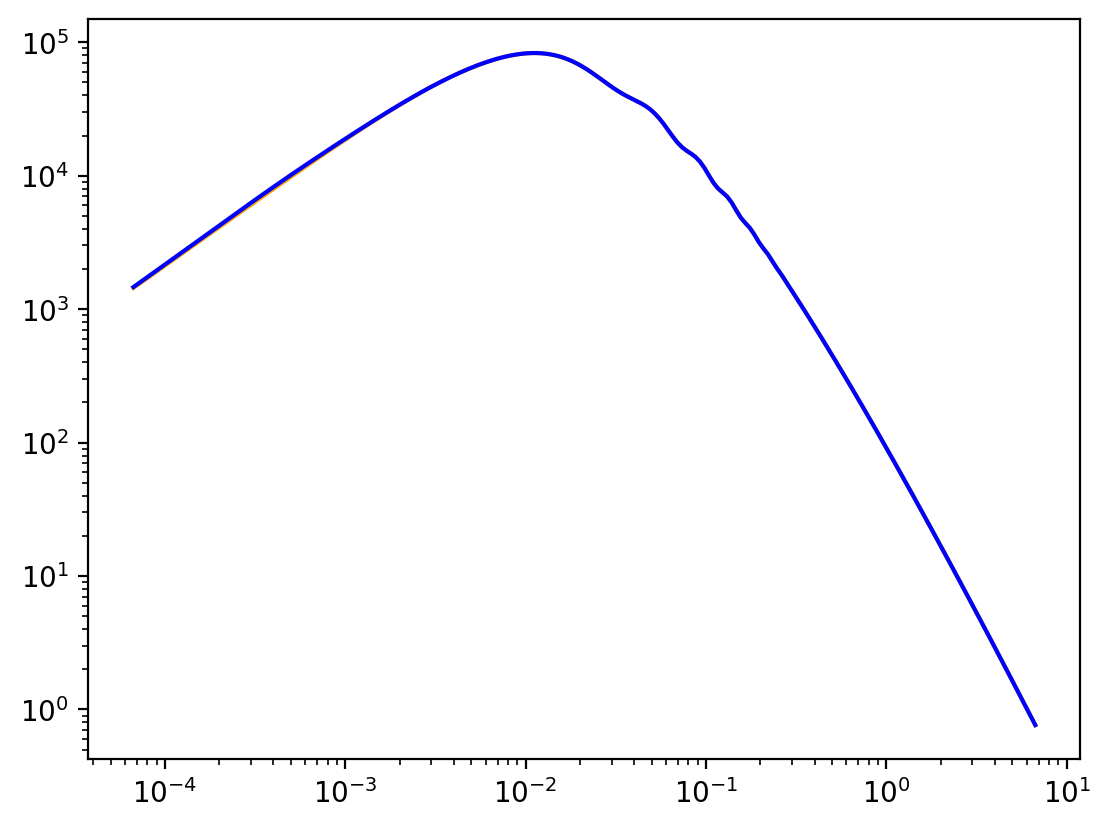

In [6]:
i = 3
snap_index = 0

baseline_h = row0["h"]
baseline_k = k0 * baseline_h
baseline_p = p0 / baseline_h ** 3

this_h = row3["h"]
this_k = k3 * this_h
this_p = p3 / this_h ** 3

plt.loglog(baseline_k, baseline_p, c="orange")
plt.loglog(this_k, this_p, c="blue")

In [7]:
def truncator(big_x, big_y, small_x, small_y, interpolation=True):
    """
    Truncate big arrays based on small_arrays,
    then interpolate the small arrays over
    the truncated big_x domain.
    @returns:
        trunc_x: truncated big_x array
        trunc_y: truncated big_y array
        aligned_y: interpolation of small_y over trunc_x
    """
    lcd_min = max(min(small_x), min(big_x))
    lcd_max = min(max(small_x), max(big_x))
    
    mask = np.all([[big_x < lcd_max], [big_x > lcd_min]], axis=0)[0]
    trunc_x = big_x[mask]
    trunc_y = big_y[mask]
    
    aligned_y = small_y[mask]
    if interpolation:
        interpolator = interp1d(small_x, small_y, kind="cubic")
        aligned_y = interpolator(trunc_x)
    
    return trunc_x, trunc_y, aligned_y

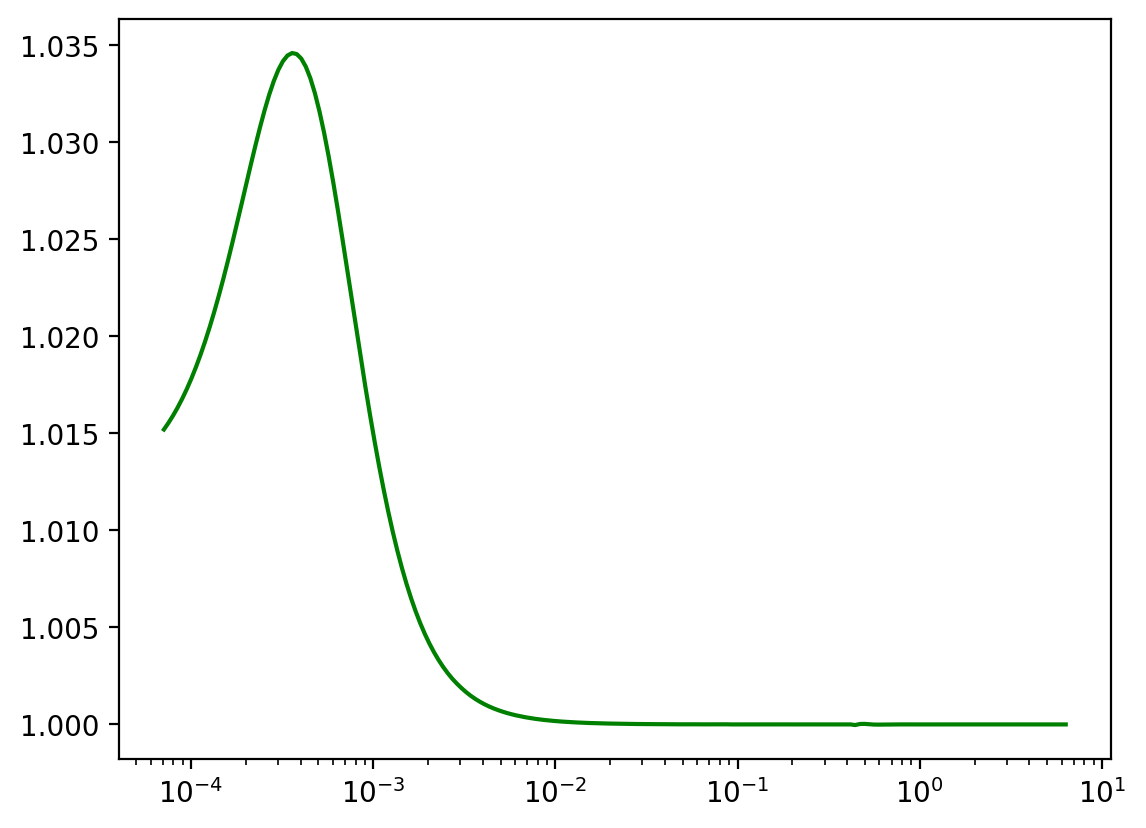

In [8]:
truncated_k, truncated_p, aligned_p = \
    truncator(baseline_k, baseline_p, this_k,
    this_p, interpolation=this_h != baseline_h)
#plt.loglog(truncated_k, truncated_p, c="orange")
#plt.loglog(truncated_k, aligned_p, c="blue")
plt.plot(truncated_k, aligned_p / truncated_p,c="green")
plt.xscale("log")